# Simple Error Model for Twinkles

This notebook will calculate a simple error model for the Twinkles data as a function of the seeing and depth.

## Motivation

The Error Model is the beginning of our science analysis with Twinkles. It has 3 major goals:

## Requirements

You will need the DESC `Monitor` and its dependencies.

You will also need the truth database for the desired Twinkles run.

In [1]:
import os
import desc.monitor
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lsst.sims.photUtils import calcNeff
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


### Get differences between true and observed fluxes

We first want to get all the differences for the run between the true and observed fluxes and store them in a Pandas Dataframe.

In [33]:
star_db_name = 'twinkles_run1.1.db'

In [34]:
truth_dbConn = desc.monitor.truthDBInterface(database=star_db_name, driver='sqlite')
dbConn_twinkles = desc.monitor.dbInterface(database='DESC_Twinkles_Level_2',
                                           host='127.0.0.1', port='3307',
                                           #host='scidb1.nersc.gov', port=3306,
                                           driver='mysql')

In [9]:
opsim_dbConn = desc.monitor.opsimDBInterface('/Users/Bryce/Desktop/kraken_1042_sqlite.db')

In [10]:
visit_info = dbConn_twinkles.get_all_visit_info()

In [11]:
opsim_info = opsim_dbConn.get_summary_depth_info_for_visits(1427)

In [12]:
opsim_info[4957], opsim_info[4958]

((503205, 0.878684, 0.572848, 23.51128, 1.005883, 'u'),
 (503205, 0.878684, 0.572848, 23.51128, 1.005883, 'u'))

In [13]:
#Find entries with the proper obsHistIds
obs_list = []
for visit_id in visit_info['visit_id']:
    obs_list.append(np.where(opsim_info['obsHistID'] == visit_id)[0][0])

In [14]:
opsim_info[obs_list]

rec.array([(    200,  0.978079,  0.74412 ,  24.234817,  1.058624, 'r'),
 (    220,  1.191609,  0.869226,  24.357859,  1.080465, 'g'),
 (    230,  1.000512,  0.791241,  23.529519,  1.094442, 'i'), ...,
 (2442772,  0.787353,  0.608037,  23.444245,  1.002575, 'i'),
 (2442775,  0.765824,  0.608037,  22.905166,  1.001921, 'z'),
 (2442799,  0.751904,  0.608037,  21.815287,  1.006113, 'y')], 
          dtype=[('obsHistID', '<i8'), ('FWHMeff', '<f8'), ('rawSeeing', '<f8'), ('fiveSigmaDepth', '<f8'), ('airmass', '<f8'), ('filter', 'S300')])

In [15]:
worker = desc.monitor.Monitor(dbConn_twinkles, truth_dbConn=truth_dbConn)

In [16]:
depth_curve = worker.measure_depth_curve()

In [17]:
seeing_curve = worker.measure_seeing_curve()

In [36]:
distances = worker.match_catalogs(return_distance=True, within_radius=1./3600.)

Querying Truth Catalog
Querying Pserv Database


/Users/Bryce/miniconda2/lib/python2.7/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


Starting angular crossmatch
Done


In [19]:
psf_area = (np.pi*(((visit_info['seeing']/2)*(1/.2))**2.))
f5 = (((5*1e9*visit_info['sky_noise'])*psf_area)/
                                            visit_info['zero_point'])

In [20]:
psf_area = calcNeff(visit_info['seeing'], 0.2)
f5 = (((5*1e9*visit_info['sky_noise'])*np.sqrt(psf_area))/visit_info['zero_point'])

In [21]:
n = visit_info['sky_noise']*np.sqrt(psf_area)
f5_signal = (1e9*(25 + 25*((1+(4*(n**2)/25))**.5))/2)/visit_info['zero_point']

Comparing 5-sigma depth:

1)  'DM': Use `seeing` from `CcdVisit` table and the following from LSE-40, 
    http://www.astro.washington.edu/users/ivezic/Teaching/Astr511/LSST_SNRdoc.pdf. We have that for a single Gaussian profile and in the $\textbf{background dominated limit}$:
    
$n_{eff} = 2.266*(\frac{seeing}{pixel\_scale})^{2}$

$SNR = \frac{Signal}{Noise}$

$SNR = \frac{Source\_Counts}{\sigma_{tot}*\sqrt{n_{eff}}}$

So that, SNR = 5 gives

$Source\_Counts_{5\sigma} = 5 * \sigma_{tot} * \sqrt{n_{eff}}$

and to convert to flux in maggies we scale by the zeropoint and then multiply by 1e9 to get nanomaggies.

$F_{5} = \frac{10^{9}* Source\_Counts_{5\sigma}}{zero\_point}$

These results are the $\color{red}{red\ line}$ in the plot below.

2)  'DM_modified': We modified the formula a bit to account for the Poisson noise of source and thus derive a general form outside of the background dominated limit.

$SNR = \frac{Signal}{\sqrt{Signal + Noise^2}}$

$SNR = 5 = \frac{Source\_Counts_{5\sigma}}{\sqrt{Source\_Counts_{5\sigma} + (\sigma_{tot}*\sqrt{n_{eff}})^2}}$

We solve this as a quadratic equation and take the positive root.

$Source\_Counts_{5\sigma} = \frac{25 + 25*\sqrt{1 + \frac{4}{25}*(\sigma_{tot}*\sqrt{n_{eff}})^2}}{2}$

These results are the $\color{blue}{blue\ line}$ in the plot below.

3) 'flux_error': Finally, we compare with our result from the Twinkles data. We pulled all objects from the visit in Twinkles 1.1 with the best seeing value and sigma clipped these objects based upon flux so that any objects that were more than 3 standard deviation from the median flux were rejected. We then randomly chose 100 of the remaining objects and kept their flux errors for all visits. Then, 5 times the median value of these flux_errors was our 5-sigma depth for a given visit. These results are the $\color{purple}{purple\ line}$ in the plot below.


(0, 350)

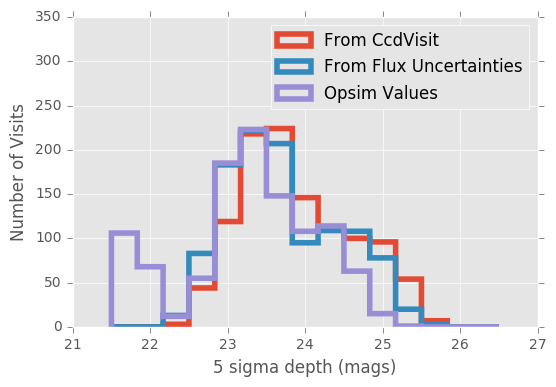

In [22]:
fig = plt.figure()
n,bins,p = plt.hist(22.5 - 2.5*np.log10(f5), histtype='step', lw=4, bins=15, label='From CcdVisit', range=(21.5,26.5))
#plt.hist(22.5 - 2.5*np.log10(f5_signal), histtype='step', lw=4, bins=bins, label='From CcdVisit Modified Formula')#, range=(20,28))
plt.hist(depth_curve.lightcurve['mag'], histtype='step',bins=bins, lw=4, label='From Flux Uncertainties')
plt.hist(opsim_info['fiveSigmaDepth'][obs_list], histtype='step', bins=bins, lw=4, label='Opsim Values')
plt.legend()
plt.xlabel('5 sigma depth (mags)')
plt.ylabel('Number of Visits')
plt.ylim(0, 350)
#plt.savefig('/Users/Bryce/Desktop/depth_compare.png')

In [23]:
opsim_info.dtype

dtype((numpy.record, [('obsHistID', '<i8'), ('FWHMeff', '<f8'), ('rawSeeing', '<f8'), ('fiveSigmaDepth', '<f8'), ('airmass', '<f8'), ('filter', 'S300')]))

In [24]:
filt_num = []
i = 0
#filt_map = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
filt_map = {'u':0, 'g':0, 'r':0, 'i':0, 'z':0, 'y':1}
not_y = []
y = []
for filt_val in opsim_info['filter'][obs_list]:
    filt_num.append(filt_map[filt_val])
    if filt_val == 'y':
        y.append(i)
    else:
        not_y.append(i)
    i+=1

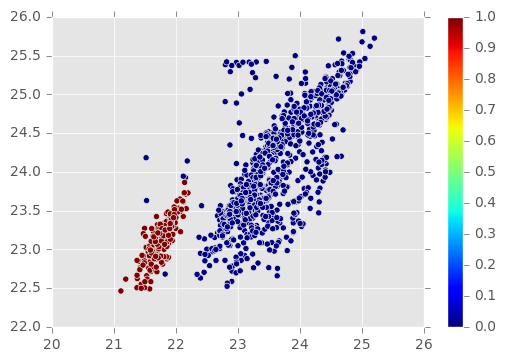

In [25]:
plt.scatter(opsim_info['fiveSigmaDepth'][obs_list], 22.5 - 2.5*np.log10(f5), c=filt_num)
plt.colorbar()

In [26]:
from sklearn.linear_model import LinearRegression as lReg

In [27]:
print len(obs_list)
random_sort = np.random.choice(np.arange(len(obs_list)), size = len(obs_list), replace=False)
#random_not_y = np.random.choice(not_y, size = len(not_y), re)
cut = 280
train = random_sort[:cut] #Split 25/75 for train/test
test = random_sort[cut:]
model = lReg()
#model.fit(opsim_info['fiveSigmaDepth'][obs_list][train].reshape(-1, 1), 
#          22.5 - 2.5*np.log10(f5[train]).reshape(-1, 1))
model.fit(np.array([opsim_info['fiveSigmaDepth'][obs_list][train], 
                    np.array(filt_num)[train]]).T.reshape(cut, 2), 
          22.5 - 2.5*np.log10(f5[train]).reshape(-1, 1))
#pred_f5 = model.predict(opsim_info['fiveSigmaDepth'][obs_list][test].reshape(-1, 1))
pred_f5 = model.predict(np.array([opsim_info['fiveSigmaDepth'][obs_list][test], 
                                  np.array(filt_num)[test]]).T.reshape(len(obs_list)-cut,2))

1120


In [28]:
model.score(np.array([opsim_info['fiveSigmaDepth'][obs_list][test], 
                      np.array(filt_num)[test]]).T.reshape(len(obs_list)-cut,2),
            22.5 - 2.5*np.log10(f5[test]))

0.62539915606000662

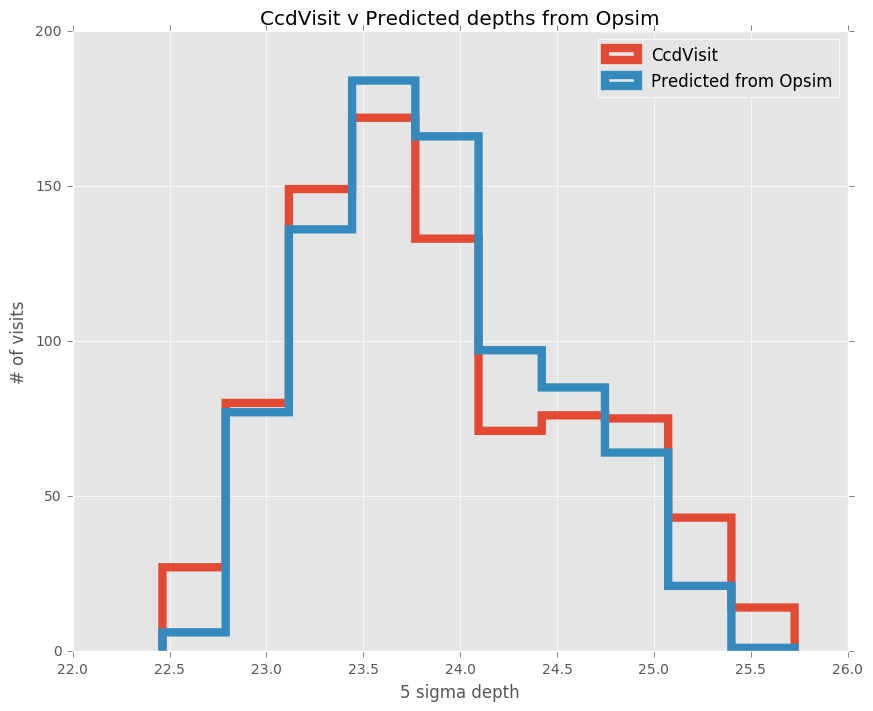

In [29]:
fig = plt.figure(figsize=(10,8))
n, bins, p = plt.hist(22.5 - 2.5*np.log10(f5[test]), histtype = 'step', lw=6)
plt.hist(pred_f5, bins=bins, histtype = 'step', lw=6)
plt.title('CcdVisit v Predicted depths from Opsim')
plt.legend(('CcdVisit', 'Predicted from Opsim'))
plt.xlabel('5 sigma depth')
plt.ylabel('# of visits')

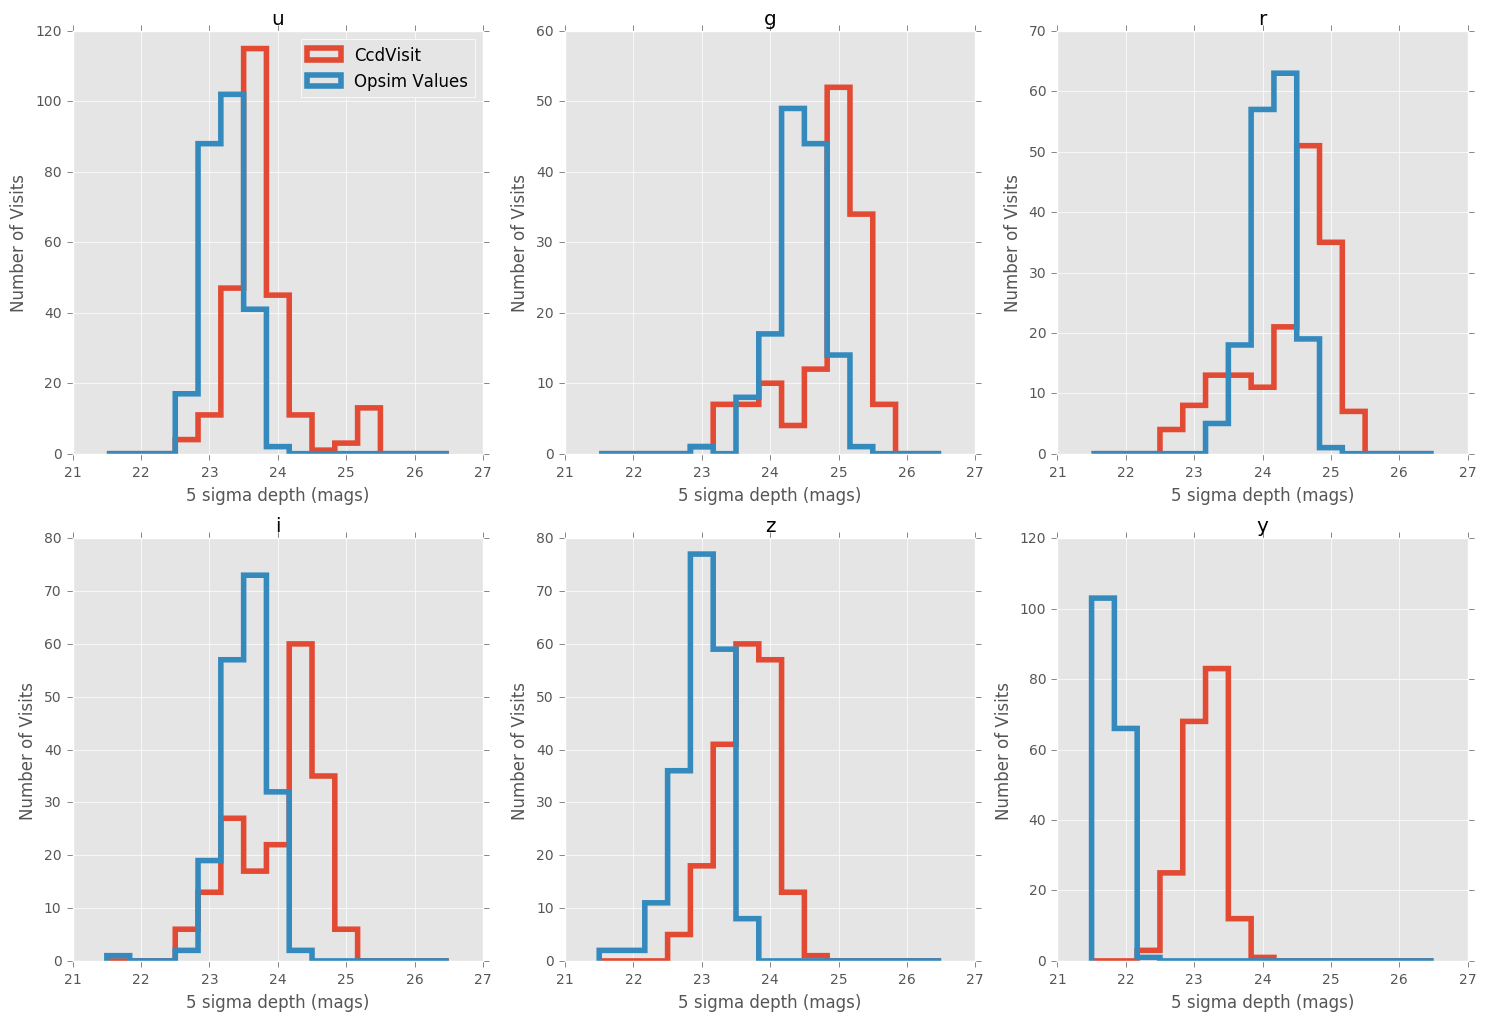

In [30]:
fig = plt.figure(figsize=(18, 12))
fig_num = 1
for filter_val in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,fig_num)
    n,bins,p = plt.hist(22.5 - 2.5*np.log10(f5[visit_info['filter'] == filter_val]), histtype='step', lw=4, bins=15, label='CcdVisit', range=(21.5,26.5))
    #plt.hist(22.5 - 2.5*np.log10(f5_signal[visit_info['filter'] == filter_val]), histtype='step', lw=4, bins=bins, label='CcdVisit Mod')#, range=(20,28))
    #plt.hist(depth_curve.lightcurve['mag'][visit_info['filter'] == filter_val], histtype='step',bins=bins, lw=4, label='Flux Uncertainty')
    plt.hist(opsim_info['fiveSigmaDepth'][obs_list][opsim_info['filter'][obs_list] == filter_val], histtype='step', bins=bins, lw=4, label='Opsim Values')
    if fig_num == 1:
        plt.legend()
    plt.xlabel('5 sigma depth (mags)')
    plt.ylabel('Number of Visits')
    #plt.ylim(0, 350)
    plt.title(filter_val)
    fig_num += 1
#plt.savefig('/Users/Bryce/Desktop/depth_compare_to_opsim.png')

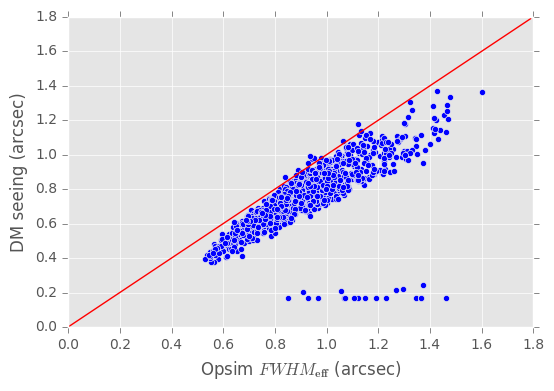

In [31]:
plt.scatter(opsim_info['FWHMeff'][obs_list], visit_info['seeing'])
plt.plot(np.arange(0, 1.8, 0.01), np.arange(0, 1.8, 0.01), c='r')
#plt.plot(np.arange(0, 1.8, 0.01), np.arange(0, 1.8, 0.01)-.12, c='k')
plt.xlim(0, 1.8)
plt.ylim(0, 1.8)
plt.xlabel(r'Opsim $FWHM_{\bf{eff}}$ (arcsec)')
plt.ylabel('DM seeing (arcsec)')
#plt.savefig('/Users/Bryce/Desktop/seeing_compare.png')

In [37]:
worker.calc_flux_residuals(with_depth_curve=depth_curve, with_seeing_curve=seeing_curve)

Gathering Visit Data
Querying for object fluxes
Loaded 0 out of 698 objects
Loaded 100 out of 698 objects
Loaded 200 out of 698 objects
Loaded 300 out of 698 objects
Loaded 400 out of 698 objects
Loaded 500 out of 698 objects
Loaded 600 out of 698 objects


/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:275: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  obs_flux_table['obs_object_id'] = obs_flux_table['obs_object_id'].convert_objects(convert_numeric=True)
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:276: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  obs_flux_table['visit_id'] = obs_flux_table['visit_id'].convert_objects(convert_numeric=True)
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:277: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  obs_flux_table['psf_flux'] = obs_flux_table['psf_flux'].convert_objects(convert_numeric=True)
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:278: Future

### Plotting Bias and Sigma

Now that we have the data we need in the form of mean flux residuals and mean squared flux residuals for each visit we can combine this with our depth and seeing information to construct plots that show the bias and sigma as functions of these values.

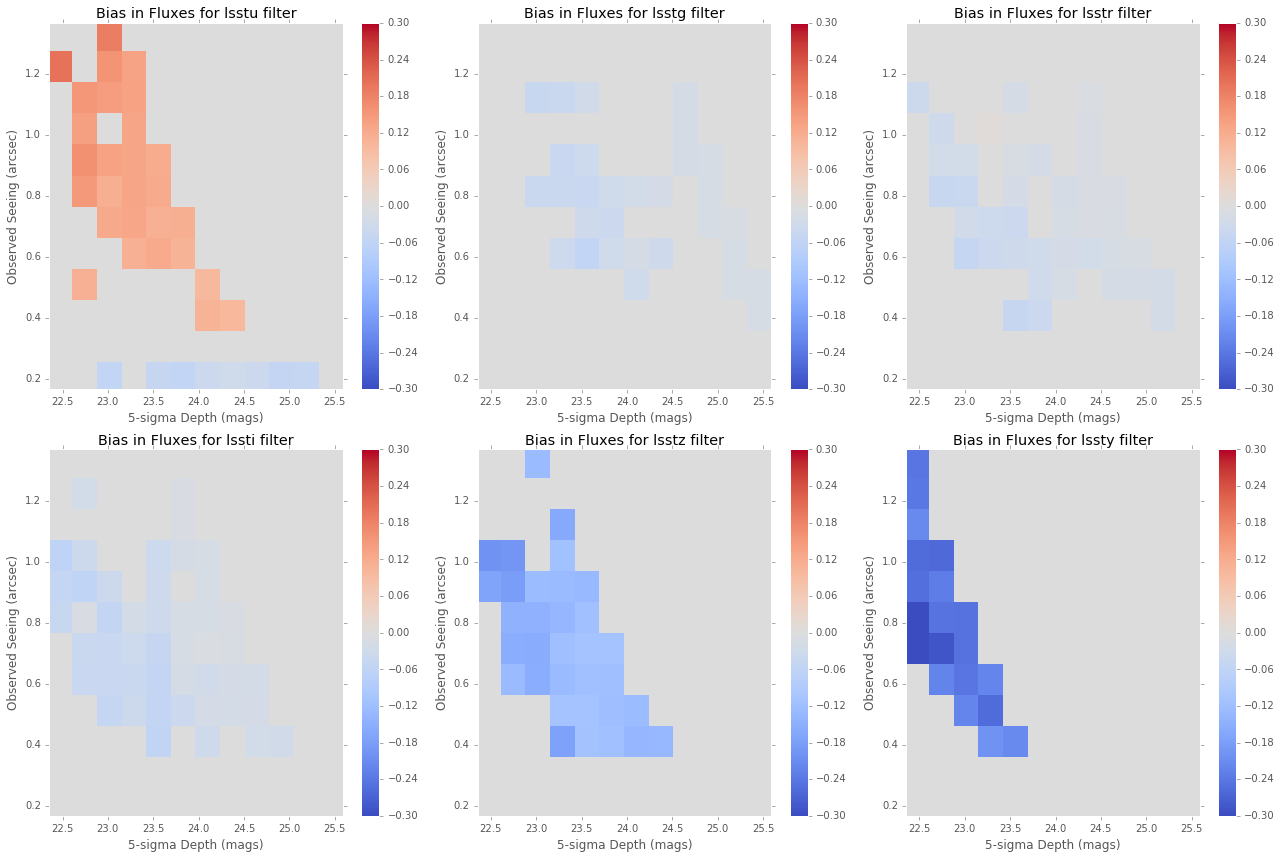

In [63]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_bias_map(with_bins=12, in_band=band, use_existing_fig=fig)
    i+=1
plt.tight_layout()
#plt.savefig('bias_old.png')

/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor

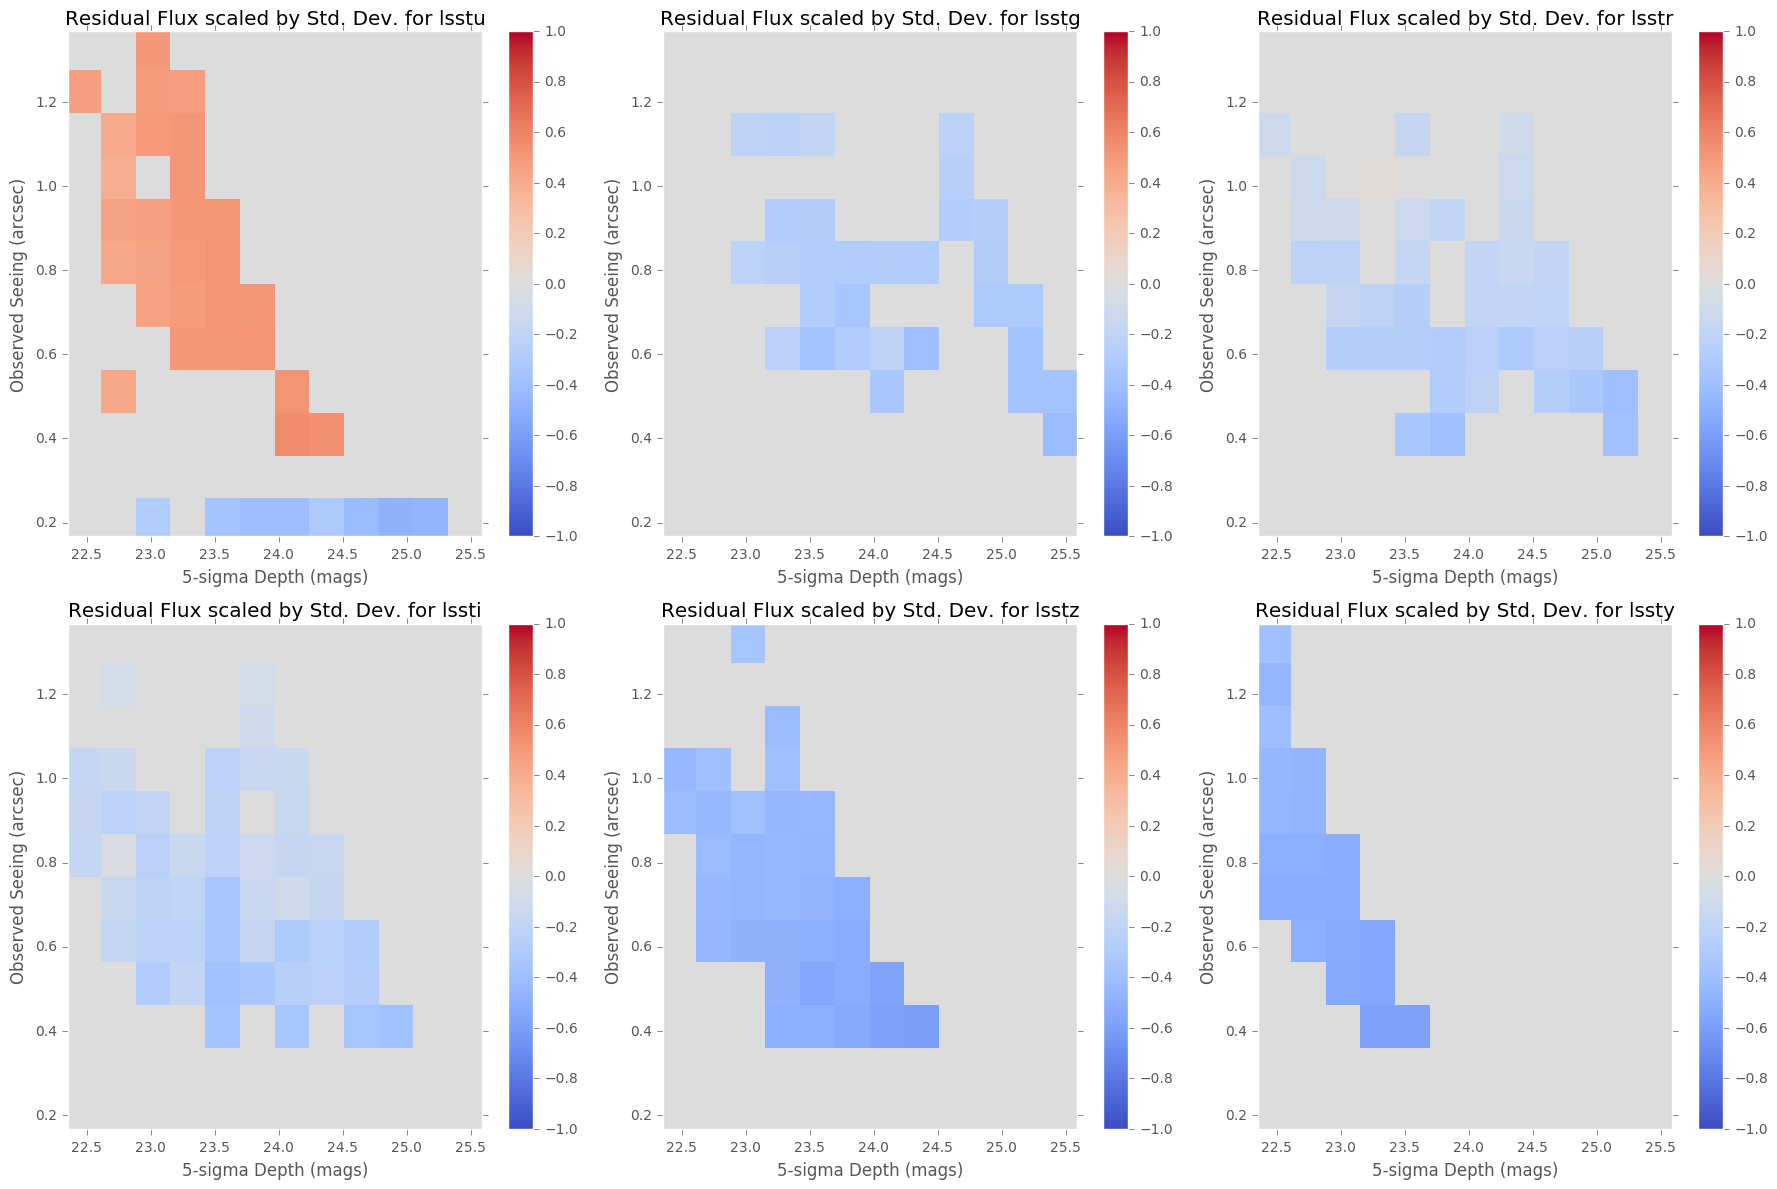

In [40]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_bias_map(with_bins=12, in_band=band, use_existing_fig=fig,
                         normalize=True)
    i+=1
    plt.title('Residual Flux scaled by Std. Dev. for lsst%s' % band)
plt.tight_layout()
plt.savefig('/Users/Bryce/Desktop/bias.png')

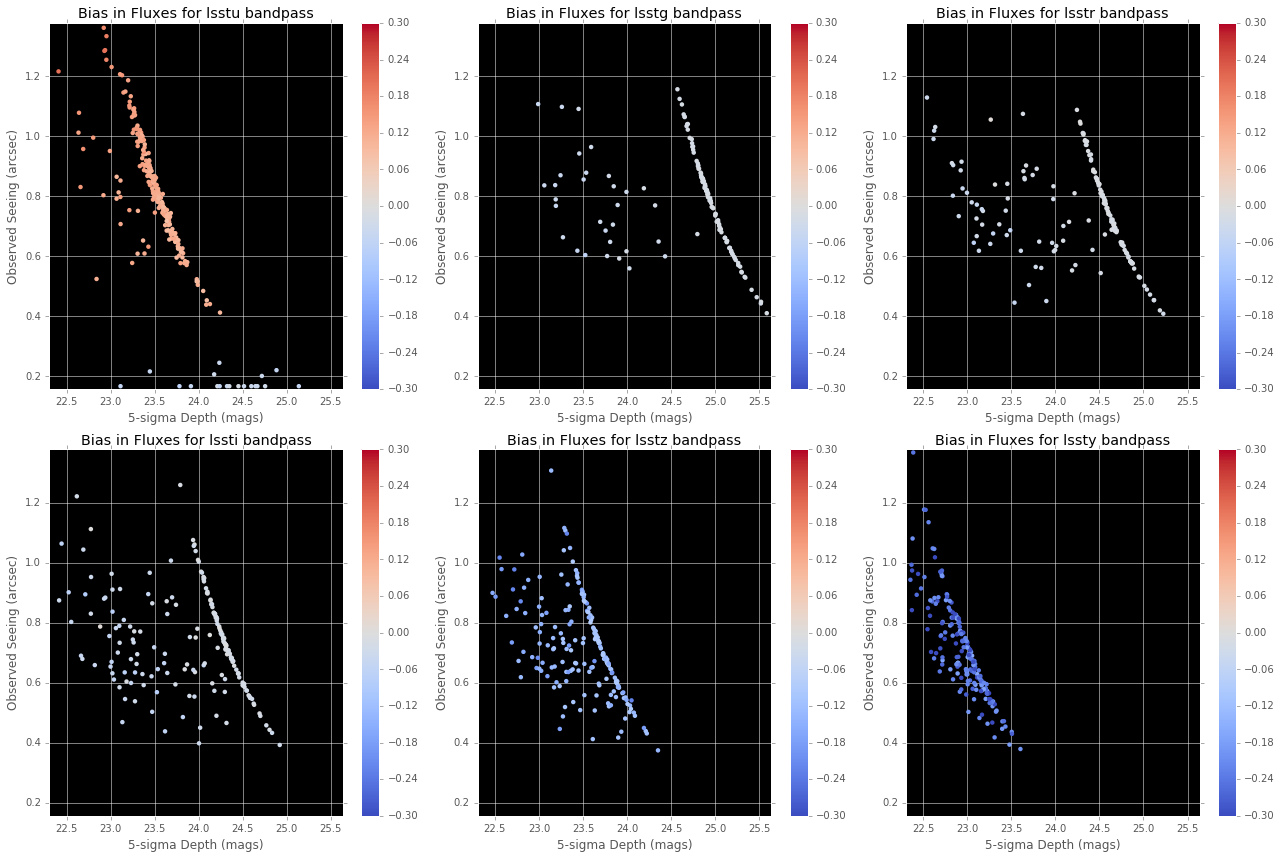

In [65]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_bias_scatter(in_band=band, use_existing_fig=fig)
    i+=1
    plt.gca().set_axis_bgcolor('k')
plt.tight_layout()
#plt.savefig('bias_new_scatter.png')

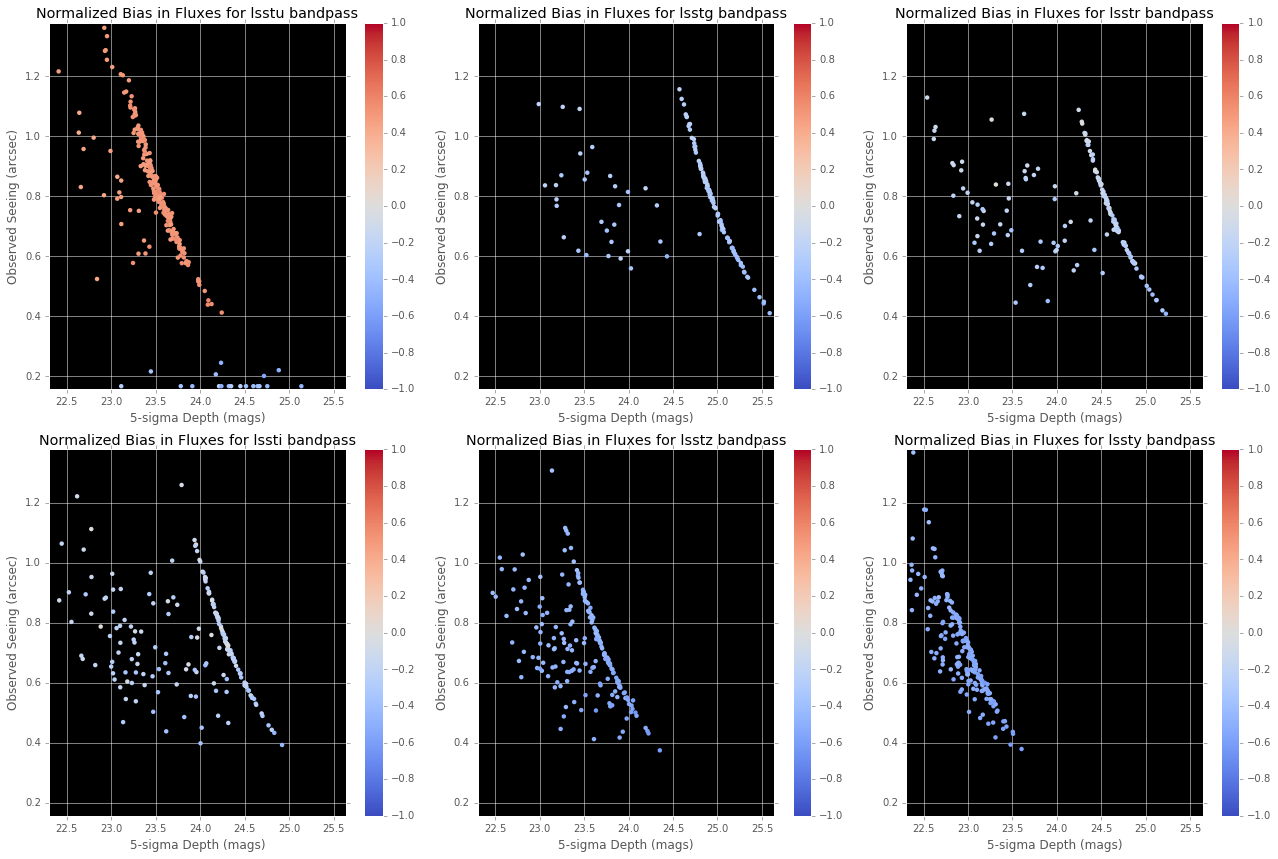

In [66]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_bias_scatter(in_band=band, use_existing_fig=fig, normalize=True)
    i+=1
    plt.gca().set_axis_bgcolor('k')
plt.tight_layout()
#plt.savefig('bias_norm_scatter.png')

/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor

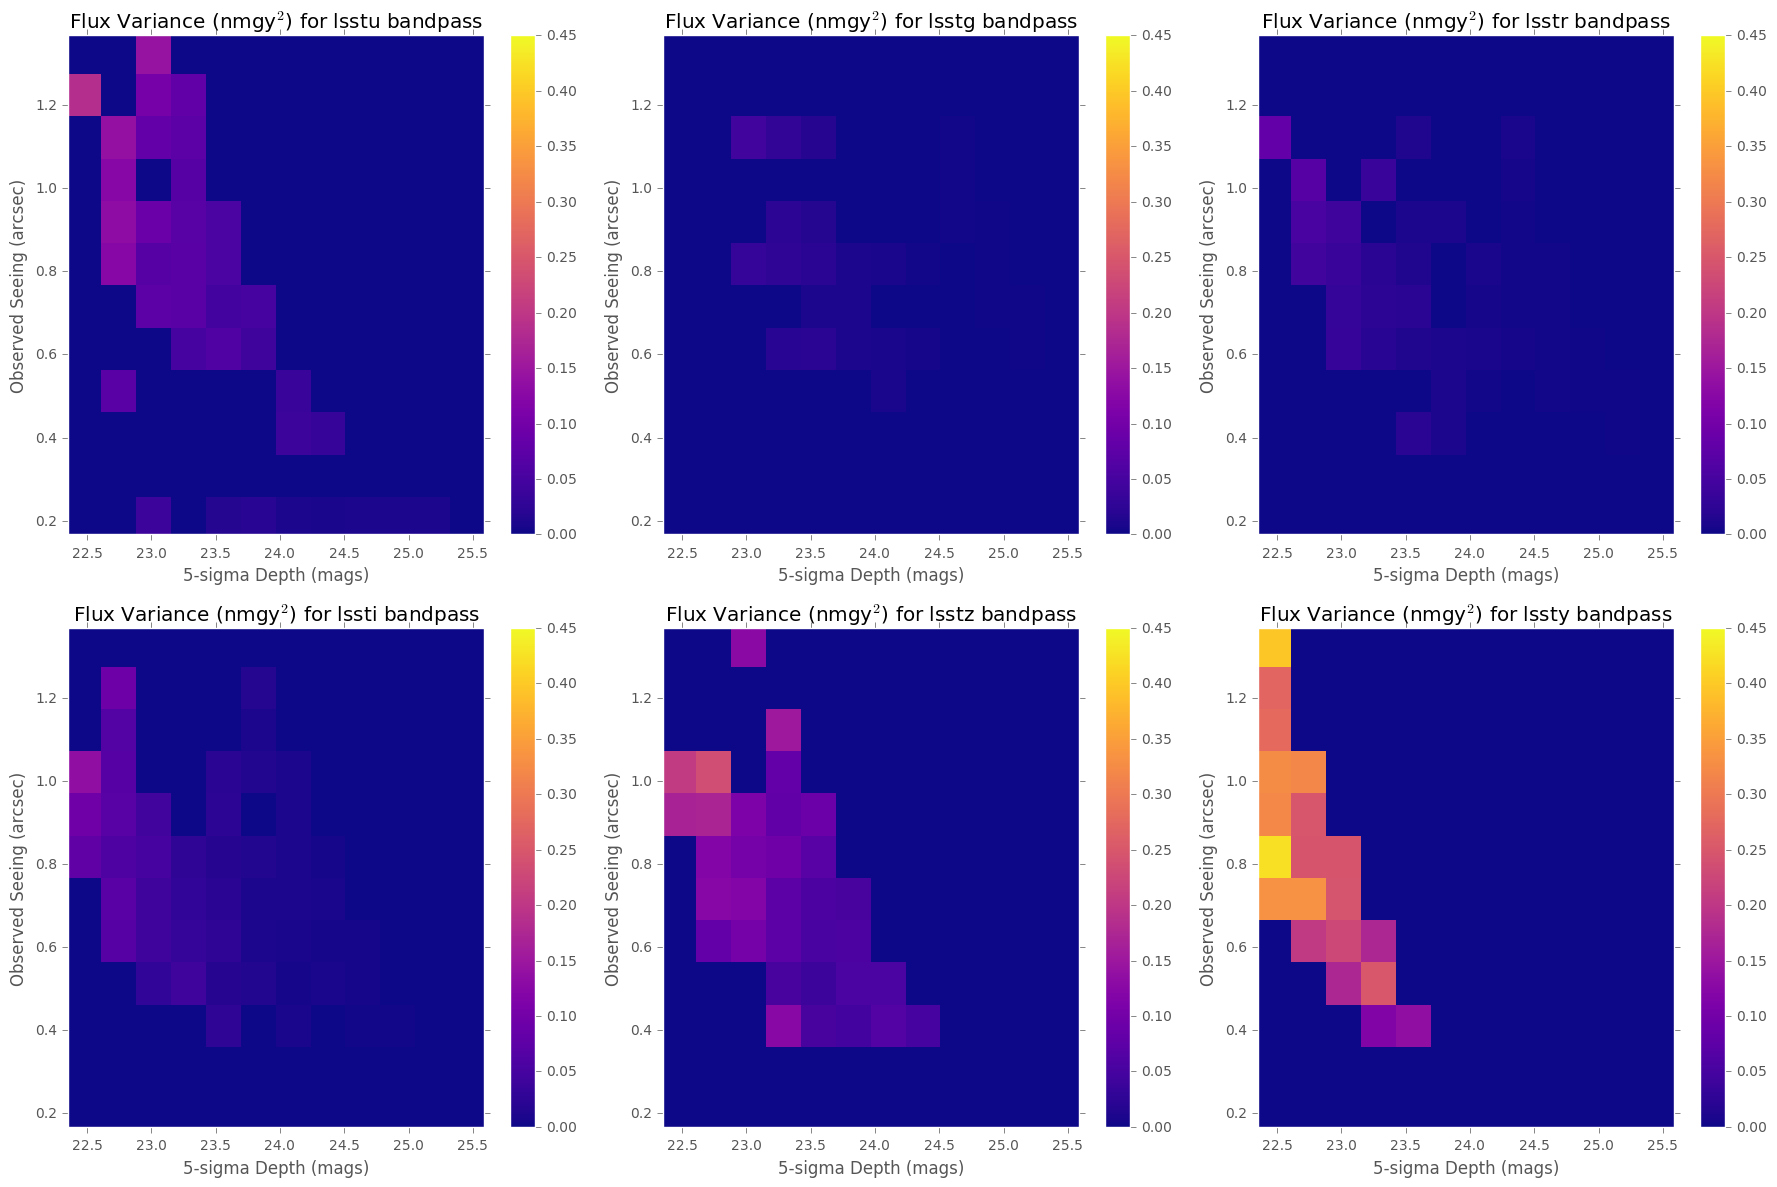

In [43]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_variance_map(with_bins=12, in_band=band, use_existing_fig=fig)
    i+=1
    plt.title(r'Flux Variance (nmgy$^{2}$) for lsst%s bandpass' % band)
plt.tight_layout()
plt.savefig('/Users/Bryce/Desktop/variance.png')

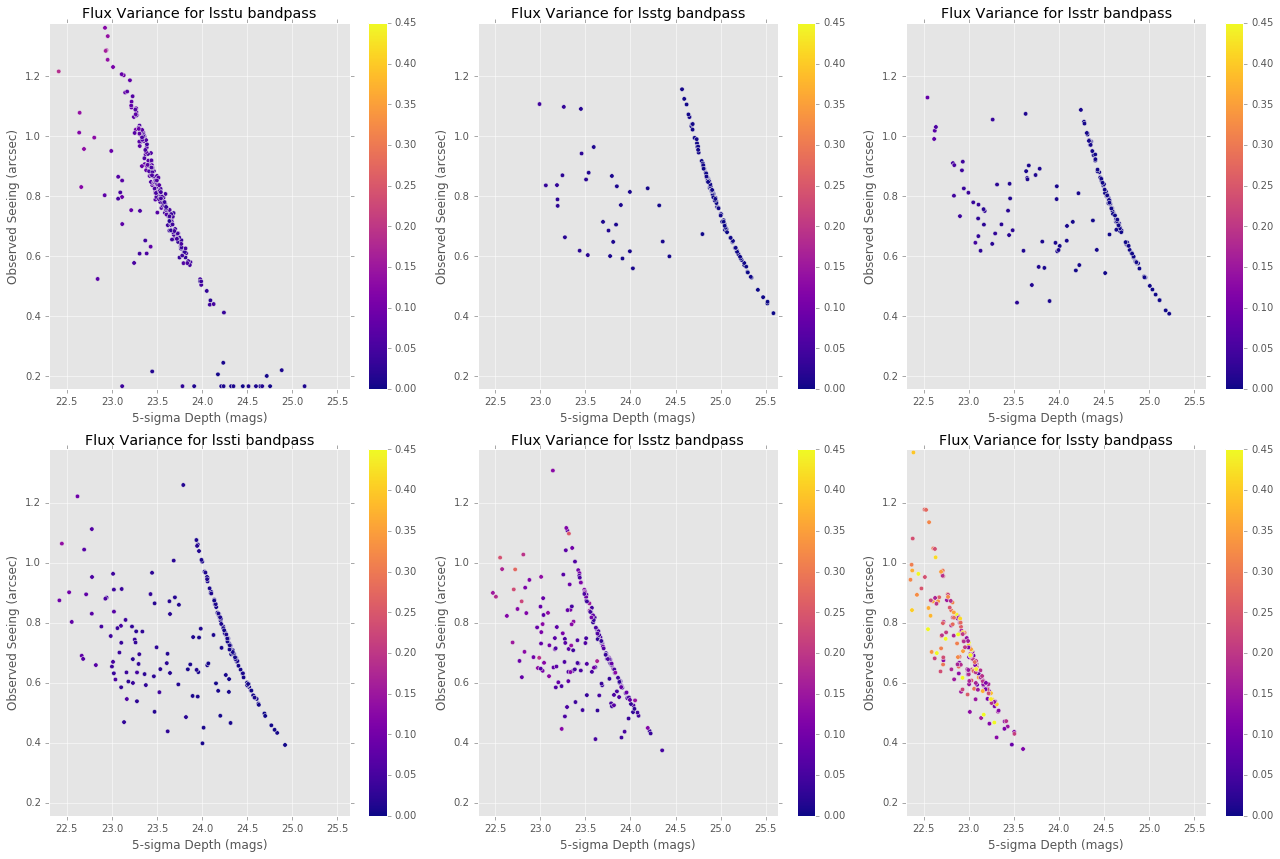

In [41]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_variance_scatter(in_band=band, use_existing_fig=fig)
    i+=1
plt.tight_layout()
#plt.savefig('variance_old_scatter.png')

In [44]:
len(visit_info)

1120